In [1]:
# encoding: utf-8

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import entropy
from IPython.display import display, HTML
from decimal import Decimal
from scipy.stats import boxcox

from my_utils.utils import *

In [3]:
my_seed = 1980

In [4]:
my_path = '../data/'

In [5]:
r = my_path + 'dados_mov.csv'
w = my_path + 'temp.csv'

In [6]:
X = pd.read_csv(w)

In [7]:
X.dtypes

vl_rend    float64
dtype: object

In [8]:
def clusters(df, col, k_min=1, k_max=10, jobs=-3):
    size = len(df)

    clusters = []
    for i in range(k_min, k_max + 1):
        print(i)
        
        kmeans = KMeans(n_clusters = i, random_state=my_seed, n_jobs=jobs)
        model = kmeans.fit(df)
        
        labels = pd.Series(model.labels_, name='label')        
        result = pd.concat([df, labels], axis=1)        
        
        counts = result.groupby(['label'])[col].count().tolist()
        ratios = [x / np.float(size) for x in counts]
        
        if i == 1:
            ent = None            
            sil = None
        else:
            ent = entropy(ratios, base=2)
            
            # need a sample due memory usage limitations
            unique_labels = np.unique(model.labels_)
            
            # stratified sample
            test = None
            for l in unique_labels:
                sample = result.loc[result['label'] == l].sample(n=400, replace=True, 
                                                                 random_state=my_seed)
            
                if test is None:
                    test = sample
                else:
                    test = test.append(sample)
            
            sil = silhouette_score(test[col].values.reshape(-1, 1), 
                                   test['label'].tolist())
        
        bins = result.groupby(['label'])[col].min().tolist()
        
        clusters.append({'n_clusters' : i, 'bins' : bins, \
                         'inertia' : kmeans.inertia_, 'silhouette' : sil, 'entropy' : ent})
    
    return pd.DataFrame(clusters)

In [9]:
clusters_pd = clusters(X, 'vl_rend')
clusters_pd

1
2
3
4
5
6
7
8
9
10


,bins,entropy,inertia,n_clusters,silhouette
0,[0.01],NaN,6.167660e+15,1,NaN
1,"[0.01, 2057679.0]",0.000263,3.655771e+15,2,0.690642
2,"[0.01, 263382.17, 2731041.41]",0.006565,2.339003e+15,3,0.597962
3,"[0.01, 2220063.12, 242023.9, 14842926.66]",0.007316,1.553505e+15,4,0.654399
4,"[0.01, 2731041.41, 113658.25, 612064.21, 14842...",0.018209,1.069156e+15,5,0.602357
5,"[0.01, 14842926.66, 1225179.37, 77704.62, 3675...",0.027110,8.136857e+14,6,0.576658
6,"[0.01, 14842926.66, 1423018.53, 106882.91, 385...",0.440511,6.283454e+14,7,0.536350
7,"[0.01, 308721.8, 2251560.8, 14842926.66, 52143...",0.488112,4.661017e+14,8,0.543450
8,"[0.01, 5326464.93, 1283480.69, 226787.03, 1484...",0.514094,3.788030e+14,9,0.543731
9,"[0.01, 1944992.2, 177484.27, 6560863.39, 23193...",0.537821,3.104795e+14,10,0.568560


In [10]:
size = len(X)

for i, row in clusters_pd.iterrows():
    ls = row['bins']
    ls.sort()
    
    ratios = []
    for j in range(len(ls)):
        if j == len(ls) - 1:
            e = u'[' + str(ls[j]) + u', +\u221E)'
            r = X.loc[X['vl_rend'] >= ls[j]]['vl_rend'].count() / np.float(size)
        else:
            e = u'[' + str(ls[j]) + ', ' + str(ls[j + 1]) + ')'
            r = X.loc[(X['vl_rend'] >= ls[j]) & (X['vl_rend'] < ls[j + 1])]['vl_rend'].count() / np.float(size)
        r = np.round(100 * r, 2)
        ratios.append({'classes' : e, 'ratio' : r})

    display(HTML(pd.DataFrame(ratios).to_html()))
    print

,classes,ratio
0,"[0.01, +∞)",100.0


,classes,ratio
0,"[0.01, 2057679.0)",100.0
1,"[2057679.0, +∞)",0.0


,classes,ratio
0,"[0.01, 263382.17)",99.95
1,"[263382.17, 2731041.41)",0.05
2,"[2731041.41, +∞)",0.00


,classes,ratio
0,"[0.01, 242023.9)",99.94
1,"[242023.9, 2220063.12)",0.06
2,"[2220063.12, 14842926.66)",0.00
3,"[14842926.66, +∞)",0.00


,classes,ratio
0,"[0.01, 113658.25)",99.84
1,"[113658.25, 612064.21)",0.15
2,"[612064.21, 2731041.41)",0.01
3,"[2731041.41, 14842926.66)",0.00
4,"[14842926.66, +∞)",0.00


,classes,ratio
0,"[0.01, 77704.62)",99.75
1,"[77704.62, 367410.24)",0.22
2,"[367410.24, 1225179.37)",0.03
3,"[1225179.37, 3675628.34)",0.00
4,"[3675628.34, 14842926.66)",0.00
5,"[14842926.66, +∞)",0.00


,classes,ratio
0,"[0.01, 10732.2)",91.28
1,"[10732.2, 106882.91)",8.54
2,"[106882.91, 443375.0)",0.15
3,"[443375.0, 1423018.53)",0.02
4,"[1423018.53, 3857385.62)",0.00
5,"[3857385.62, 14842926.66)",0.00
6,"[14842926.66, +∞)",0.00


,classes,ratio
0,"[0.01, 9885.73)",89.97
1,"[9885.73, 82195.35)",9.79
2,"[82195.35, 308721.8)",0.20
3,"[308721.8, 844711.66)",0.03
4,"[844711.66, 2251560.8)",0.01
5,"[2251560.8, 5214383.74)",0.00
6,"[5214383.74, 14842926.66)",0.00
7,"[14842926.66, +∞)",0.00


,classes,ratio
0,"[0.01, 9438.39)",89.29
1,"[9438.39, 65355.12)",10.40
2,"[65355.12, 226787.03)",0.24
3,"[226787.03, 572579.04)",0.05
4,"[572579.04, 1283480.69)",0.01
5,"[1283480.69, 2731041.41)",0.00
6,"[2731041.41, 5326464.93)",0.00
7,"[5326464.93, 14842926.66)",0.00
8,"[14842926.66, +∞)",0.00


,classes,ratio
0,"[0.01, 9074.29)",88.68
1,"[9074.29, 53731.54)",10.94
2,"[53731.54, 177484.27)",0.29
3,"[177484.27, 432418.81)",0.07
4,"[432418.81, 925506.05)",0.02
5,"[925506.05, 1944992.2)",0.00
6,"[1944992.2, 3675628.34)",0.00
7,"[3675628.34, 6560863.39)",0.00
8,"[6560863.39, 23193027.79)",0.00
9,"[23193027.79, +∞)",0.00


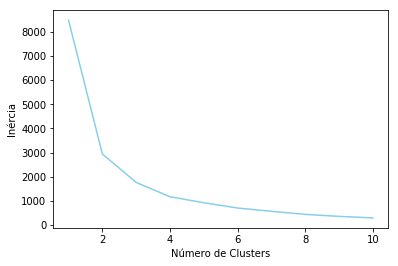

In [17]:
plt.plot(clusters_pd['n_clusters'], clusters_pd['inertia'], color='skyblue')
plt.xlabel(u'Número de Clusters')
plt.ylabel(u'Inércia') # within cluster sum of squares
plt.show()

In [9]:
ls, lbd, mib, mia, maa = bc_n_scale_list(X['vl_rend'].tolist())

In [10]:
Y = pd.DataFrame(pd.Series(ls, name='scaled'))

In [14]:
clusters_pd = clusters(Y, 'scaled')
clusters_pd

1
2
3
4
5
6
7
8
9
10


,bins,entropy,inertia,n_clusters,silhouette
0,[0.0],NaN,8470.153235,1,NaN
1,"[0.815940411288, 0.0]",0.972323,2942.042425,2,0.571988
2,"[0.0, 0.80203927326, 0.836168538663]",1.519731,1765.861748,3,0.535687
3,"[0.788289714822, 0.843640783988, 0.0, 0.814199...",1.932124,1173.819564,4,0.543100
4,"[0.768610127262, 0.81826116786, 0.0, 0.8461642...",2.088295,926.064941,5,0.507345
5,"[0.828876876403, 0.788727909811, 0.85258750673...",2.325649,706.969122,6,0.516831
6,"[0.788816664495, 0.828904778445, 0.85260525847...",2.330304,572.335642,7,0.537785
7,"[0.78735946475, 0.820654761698, 0.861272369441...",2.549027,444.976735,8,0.540645
8,"[0.803462172343, 0.853071715528, 0.76024870344...",2.644921,362.761922,9,0.538457
9,"[0.757550498347, 0.80578572913, 0.835805765271...",2.885171,298.488205,10,0.520768


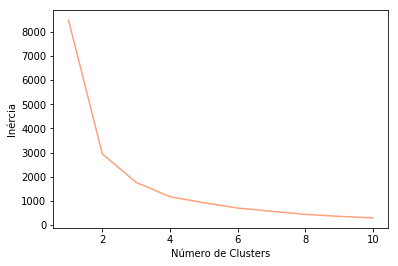

In [18]:
plt.plot(clusters_pd['n_clusters'], clusters_pd['inertia'], color='lightsalmon')
plt.xlabel(u'Número de Clusters')
plt.ylabel(u'Inércia') # within cluster sum of squares
plt.show()

In [19]:
size = len(X)

for i, row in clusters_pd.iterrows():
    ls_scaled = row['bins']
    ls = inv_bc_scale_list(ls_scaled, lbd, mib, mia, maa)
    ls.sort()
    
    ratios = []
    for j in range(len(ls)):
        if j == len(ls) - 1:
            e = u'[' + str(ls[j]) + u', +\u221E)'
            r = X.loc[X['vl_rend'] >= ls[j]]['vl_rend'].count() / np.float(size)
        else:
            e = u'[' + str(ls[j]) + ', ' + str(ls[j + 1]) + ')'
            r = X.loc[(X['vl_rend'] >= ls[j]) & (X['vl_rend'] < ls[j + 1])]['vl_rend'].count() / np.float(size)
        r = np.round(100 * r, 2)
        ratios.append({'classes' : e, 'ratio' : r})

    display(HTML(pd.DataFrame(ratios).to_html()))
    print

,classes,ratio
0,"[0.01, +∞)",100.0


,classes,ratio
0,"[0.01, 2958.28)",59.76
1,"[2958.28, +∞)",40.24


,classes,ratio
0,"[0.01, 1920.9)",43.79
1,"[1920.9, 5752.11)",35.84
2,"[5752.11, +∞)",20.36


,classes,ratio
0,"[0.01, 1276.17)",22.24
1,"[1276.17, 2799.55)",35.51
2,"[2799.55, 7442.85)",27.51
3,"[7442.85, +∞)",14.74


,classes,ratio
0,"[0.01, 731.34)",3.52
1,"[731.34, 1538.56)",27.35
2,"[1538.56, 3185.52)",31.56
3,"[3185.52, 8132.37)",24.40
4,"[8132.37, +∞)",13.16


,classes,ratio
0,"[0.01, 562.13)",1.59
1,"[562.13, 1292.57)",21.12
2,"[1292.57, 2331.94)",28.47
3,"[2331.94, 4502.18)",21.96
4,"[4502.18, 10227.8)",17.42
5,"[10227.8, +∞)",9.43


,classes,ratio
0,"[0.01, 11.59)",0.01
1,"[11.59, 591.82)",1.67
2,"[591.82, 1295.92)",21.12
3,"[1295.92, 2334.8)",28.44
4,"[2334.8, 4506.35)",21.93
5,"[4506.35, 10234.36)",17.41
6,"[10234.36, +∞)",9.42


,classes,ratio
0,"[0.01, 11.59)",0.01
1,"[11.59, 583.93)",1.65
2,"[583.93, 1242.11)",19.53
3,"[1242.11, 2045.4)",25.08
4,"[2045.4, 3440.25)",17.87
5,"[3440.25, 6414.56)",18.05
6,"[6414.56, 14069.3)",12.55
7,"[14069.3, +∞)",5.26


,classes,ratio
0,"[0.01, 11.59)",0.01
1,"[11.59, 582.72)",1.65
2,"[582.72, 1234.39)",19.31
3,"[1234.39, 2005.95)",24.60
4,"[2005.95, 3267.84)",17.33
5,"[3267.84, 5604.76)",16.40
6,"[5604.76, 10408.41)",11.56
7,"[10408.41, 27048.83)",8.05
8,"[27048.83, +∞)",1.10


,classes,ratio
0,"[0.01, 11.36)",0.01
1,"[11.36, 542.14)",1.48
2,"[542.14, 1036.67)",12.51
3,"[1036.67, 1474.72)",14.18
4,"[1474.72, 2153.91)",20.00
5,"[2153.91, 3364.71)",15.27
6,"[3364.71, 5681.58)",16.04
7,"[5681.58, 10588.34)",11.61
8,"[10588.34, 28171.14)",7.88
9,"[28171.14, +∞)",1.01


In [20]:
ALPHA_THRESHOLD = 10000

In [21]:
c0 = np.mean(X.loc[X['vl_rend'] < ALPHA_THRESHOLD, 'vl_rend'])
c0

2824.685124835135

In [22]:
c1 = np.mean(X.loc[X['vl_rend'] >= ALPHA_THRESHOLD, 'vl_rend'])
c1

22530.76775945782

In [23]:
sse = 0
for i, r in X.iterrows():
    if r['vl_rend'] < ALPHA_THRESHOLD:
        sse += (r['vl_rend'] - c0)**2
    else:
        sse += (r['vl_rend'] - c1)**2
print sse

5.82416207647e+15


In [24]:
'%.2E' % Decimal(sse)

'5.82E+15'

In [25]:
g0 = X.loc[X['vl_rend'] < ALPHA_THRESHOLD, 'vl_rend'].count() / np.float(size)
g1 = X.loc[X['vl_rend'] >= ALPHA_THRESHOLD, 'vl_rend'].count() / np.float(size)
ratio = (g0, g1)

entropy(ratio, base=2)

0.46475859401760855

In [26]:
Z = X
Z['label'] = Z.apply(lambda row : 0 if row['vl_rend'] < ALPHA_THRESHOLD else 1, axis=1)

In [27]:
s0 = Z.loc[Z['label'] == 0].sample(n=400, replace=True, random_state=my_seed)
s1 = Z.loc[Z['label'] == 1].sample(n=400, replace=True, random_state=my_seed)
test = pd.concat([s0, s1])

silhouette_score(test['vl_rend'].values.reshape(-1, 1), test['label'].tolist())

0.25429302936348319

In [28]:
pd.DataFrame([
    {'classes' : '[0.01, 10000)', 'ratio' : np.round(100 * ratio[0], 2)},
    {'classes' : u'[10000, +\u221E)', 'ratio' : np.round(100 * ratio[1], 2)}
])

,classes,ratio
0,"[0.01, 10000)",90.13
1,"[10000, +∞)",9.87


In [15]:
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if plt.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

formatter = FuncFormatter(to_percent)    

In [21]:
vl_min = np.min(X['vl_rend'])
vl_max = np.max(X['vl_rend'])

In [22]:
X['scaled'] = X['vl_rend'].apply(lambda x: (x - vl_min) / np.float(vl_max - vl_min))

In [31]:
Y['vl_rend'] = Y['scaled'].apply(lambda x: x * (vl_max - vl_min)  + vl_min)

In [42]:
vl_min = np.min(X['vl_rend'].tolist() + Y['vl_rend'].tolist())
vl_max = np.max(X['vl_rend'].tolist() + Y['vl_rend'].tolist())

In [43]:
vl_min

0.01

In [44]:
vl_max

23429114.530000001

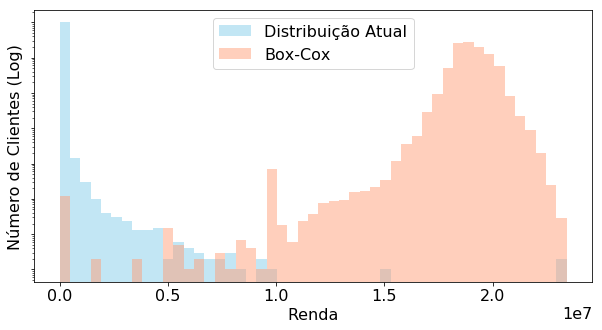

In [45]:
bins = np.linspace(vl_min, vl_max, 50)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(X['vl_rend'], bins, alpha=.5 ,label=u'Distribuição Atual', color='skyblue', log=True)
ax.hist(Y['vl_rend'], bins, alpha=.5, label='Box-Cox', color='lightsalmon', log=True)
ax.set_ylabel(u'Número de Clientes (Log)')
ax.set_xlabel('Renda')
ax.legend(loc='upper center')
# plt.gca().yaxis.set_visible(False)

# Turn off tick labels
ax.set_yticklabels([])

plt.rcParams.update({'font.size': 16})

plt.show()